# <font color=black>Machine Learning Algorithm to Detect Potential Bike Share Demand

Written in January 2023 by ZMS. Looks to use historic data to train and test a model built to look at the bike share demand during given conditions.

## <font color=blue>Libraries

In [136]:
#general libraries
import pandas as pd
import numpy as np
import math
import os
import datetime
import statistics

#plotting mods
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FixedLocator, FixedFormatter

#sklearn modules for preprocessing and transformation
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, StandardScaler, OrdinalEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error

## <font color=blue>Function Definitions

In [3]:
from sklearn.model_selection import learning_curve

def plot_learning_curve1(estimator,X,y,ylim=None,cv=None,n_jobs=None,train_sizes=np.linspace(0.1, 1.0, 20),scoring = 'neg_root_mean_squared_error'):
    
    _, axes = plt.subplots(1, 1, figsize=(10, 5))    
    axes.set_title('Learning Curve')
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel(scoring)

    train_sizes, train_scores, test_scores= learning_curve(estimator,X,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes,scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes,train_scores_mean - train_scores_std,train_scores_mean + train_scores_std,alpha=0.1,color="r")
    axes.fill_between(train_sizes,test_scores_mean - test_scores_std,test_scores_mean + test_scores_std,alpha=0.1,color="g")
    axes.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    axes.legend(loc="best")
    plt.show()
    
    return

## <font color=blue>Import Data

In [73]:
path = '/Users/zoespiegelhoff/Downloads'
os.chdir(path)

test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [74]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [75]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


## <font color=blue>Data Cleansing & Manipulation

In [76]:
##need to manipulate the date to a readable form in terms of day, month, year and hour
#is date a datetime?
train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [77]:
#same with test
test.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
dtype: object

In [78]:
#change date to datetime
train['datetime']= pd.to_datetime(train['datetime'])

test['datetime']= pd.to_datetime(test['datetime'])

In [79]:
##split all into month/day/year/hr
#splitting date
train["month"] = (
    train['datetime'].dt.month
)
train["year"] = (
    train['datetime'].dt.year
)
train["day"] = (
    train['datetime'].dt.day
)
train["hour"] = (
    train['datetime'].dt.hour
)

In [80]:
##split all into month/day/year/hr
#splitting date
test["month"] = (
    test['datetime'].dt.month
)
test["year"] = (
    test['datetime'].dt.year
)
test["day"] = (
    test['datetime'].dt.day
)
test["hour"] = (
    test['datetime'].dt.hour
)

In [104]:
#drop datetimes
train.drop(columns=['datetime'], inplace = True)
test.drop(columns=['datetime'], inplace=True)

KeyError: "['datetime'] not found in axis"

In [105]:
#also drop casual and registered
#count will be out "y" or output
train.drop(columns=['casual', 'registered'], inplace = True)

KeyError: "['casual' 'registered'] not found in axis"

In [106]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,month,year,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,1,2011,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,1,2011,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,1,2011,1,2
3,1,0,0,1,9.84,14.395,75,0.0,13,1,2011,1,3
4,1,0,0,1,9.84,14.395,75,0.0,1,1,2011,1,4


In [107]:
test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,year,day,hour
0,1,0,1,1,10.66,11.365,56,26.0027,1,2011,20,0
1,1,0,1,1,10.66,13.635,56,0.0000,1,2011,20,1
2,1,0,1,1,10.66,13.635,56,0.0000,1,2011,20,2
3,1,0,1,1,10.66,12.880,56,11.0014,1,2011,20,3
4,1,0,1,1,10.66,12.880,56,11.0014,1,2011,20,4


In [114]:
#split the training dataset into X and Y, define x test
Y_train = train['count']
X_train = train.drop(columns=['count'])

X_test = test

In [115]:
#check if df looks good
X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,year,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,1,2011,1,0
1,1,0,0,1,9.02,13.635,80,0.0,1,2011,1,1
2,1,0,0,1,9.02,13.635,80,0.0,1,2011,1,2
3,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,3
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,4


In [116]:
Y_train.head()

0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [117]:
#discern between attribs
cat_attribs = ["season", "holiday", "workingday", "weather"]
num_attribs = list( X_train.drop(columns=cat_attribs) )

#create pipeline
num_pipeline = Pipeline( [
 ('imputer', SimpleImputer(strategy="median")),
 ('std_scaler', StandardScaler()),   
])

full_pipeline = ColumnTransformer( [
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

#pipeline X train and X test
X_train = full_pipeline.fit_transform(X_train)

X_test = full_pipeline.transform(X_test)

X_train.shape, Y_train.shape

((10886, 20), (10886,))

In [118]:
Y_train.head()

0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

## <font color=blue>Establish a Baseline RMSE

In [131]:
#baseline determination
baseline_prediction = Y_train.median()
predictions = np.full(shape=10886, fill_value = baseline_prediction)
baseline_rmse = mean_squared_error(Y_train, predictions, squared=False)
print(baseline_rmse)

187.02793547928005


## <font color=blue>Linear Regression

In [132]:
#linear regression
lin_reg = LinearRegression()
lin_reg.fit(X_train,Y_train)
predictions = lin_reg.predict(X_train)
lin_rmse = mean_squared_error(Y_train, predictions, squared=False)
print(lin_rmse)

140.62048244219505


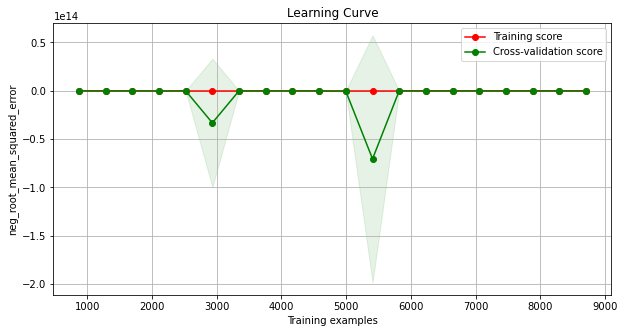

In [133]:
plot_learning_curve1(lin_reg, X_train, Y_train)

In [139]:
#eval test set
Y_test = lin_reg.predict(X_test)

prediction = statistics.median(Y_test)
predictions = np.full(shape=6493, fill_value = prediction)

linreg_mse = mean_squared_error(Y_test, predictions, squared=False)
print(linreg_mse)

112.35880726448934
